# Abstract
Calculating the atomization energy is of a molecule is a valuable but computationally expensive task using quantum mechanical simulations.   The report below investigates a data set consisting of the properties of 16,242 molecules from the PubChem chemical compound database in attempt to develop supervised ML (Machine Learning) algorithms to predict the atomization energy of a molecule without the computational cost of a quantum mechanical simulation. This first part of this notebook follows the following competition hosted on Kaggle and the associated notebooks and research papers presented in https://www.kaggle.com/burakhmmtgl/energy-molecule.

# Dataset
The ground state energies (from which the atomization energies are derived) of 16,242 molecules composed of elements C, H, N, O, P, and S have been extracted from the PubChem chemical compound database and posed in the Kaggle competition and the following GitHub repository https://github.com/bhimmetoglu/RoboBohr/blob/master/README.md. The data is organized by rows tagged with a PubChem molecule ID, 1275 columns of features and 1 column of atomization energies calculated from quantum mechanical simulations (‘Eat’) as shown in Figure 1 below.

The feature space can is a flattened version of the coulomb matrix associated with each molecule where the coulomb matrix is a representation of the electrostatic interactions between each atom and every other atom in the molecule. (Himmetoglu, 2016)

The coulomb matrices used in this data set are limited to molecules consisting of 50 atoms or less. Coulomb matrices of molecules with less than 50 atoms are populated with 0 in accordance with the molecule. The flattened 1275 dimensional raw data represents the upper left triangle of the 50x50 coulomb matrix and drops the redundant lower right triangle.
The data that will be inputted into the supervised ML algorithms in this assignment are the eigenvalues of each coulomb matrix mapped to the calculated atomization energies.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

C:\Users\Karan\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
path = 'C:/Users/Karan/Desktop/energy-molecule'

In [7]:
df = pd.read_csv(path + '/roboBohr.csv')

In [8]:
df.head(10)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1267,1268,1269,1270,1271,1272,1273,1274,pubchem_id,Eat
0,0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,25004,-19.013763
1,1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25005,-10.161019
2,2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25006,-9.376619
3,3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25009,-13.776438
4,4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25011,-8.537140
5,5,53.358707,17.038820,16.981436,16.167446,16.137631,16.053239,15.713944,15.432893,15.421116,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25017,-16.169604
6,6,53.358707,17.040919,16.975955,16.168874,16.131888,16.073074,15.843838,15.638061,15.160532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25019,-17.378477
7,7,53.358707,15.190748,15.134397,15.078282,13.721467,13.720334,13.671396,13.655370,13.654554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25023,-15.673737
8,8,73.516695,20.648642,18.559611,17.674347,16.152675,14.266867,13.666125,13.657868,13.642132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25032,-10.427851
9,9,73.516695,17.563342,17.562598,12.653657,12.540799,12.539160,12.536825,12.508203,12.489843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25042,-8.744178


In [9]:
df_master = df.drop(['Unnamed: 0', 'pubchem_id'], axis = 1)
df_eat = df_master['Eat']
df_features = df_master.drop('Eat', axis = 1)

In [10]:
df_master.head(10)

,0,1,2,3,4,5,6,7,8,9,...,1266,1267,1268,1269,1270,1271,1272,1273,1274,Eat
0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,12.365984,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,-19.013763
1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,15.227643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10.161019
2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,8.698826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.376619
3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,12.444141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-13.776438
4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,10.595914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.537140
5,53.358707,17.038820,16.981436,16.167446,16.137631,16.053239,15.713944,15.432893,15.421116,13.799676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-16.169604
6,53.358707,17.040919,16.975955,16.168874,16.131888,16.073074,15.843838,15.638061,15.160532,13.712149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-17.378477
7,53.358707,15.190748,15.134397,15.078282,13.721467,13.720334,13.671396,13.655370,13.654554,13.654217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-15.673737
8,73.516695,20.648642,18.559611,17.674347,16.152675,14.266867,13.666125,13.657868,13.642132,13.629813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10.427851
9,73.516695,17.563342,17.562598,12.653657,12.540799,12.539160,12.536825,12.508203,12.489843,11.941684,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.744178


In [11]:
df_features.head(10)

,0,1,2,3,4,5,6,7,8,9,...,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274
0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,12.365984,...,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,15.227643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,8.698826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,12.444141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,10.595914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,53.358707,17.038820,16.981436,16.167446,16.137631,16.053239,15.713944,15.432893,15.421116,13.799676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,53.358707,17.040919,16.975955,16.168874,16.131888,16.073074,15.843838,15.638061,15.160532,13.712149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,53.358707,15.190748,15.134397,15.078282,13.721467,13.720334,13.671396,13.655370,13.654554,13.654217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,73.516695,20.648642,18.559611,17.674347,16.152675,14.266867,13.666125,13.657868,13.642132,13.629813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,73.516695,17.563342,17.562598,12.653657,12.540799,12.539160,12.536825,12.508203,12.489843,11.941684,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df_eat.head(10)

0   -19.013763
1   -10.161019
2    -9.376619
3   -13.776438
4    -8.537140
5   -16.169604
6   -17.378477
7   -15.673737
8   -10.427851
9    -8.744178
Name: Eat, dtype: float64

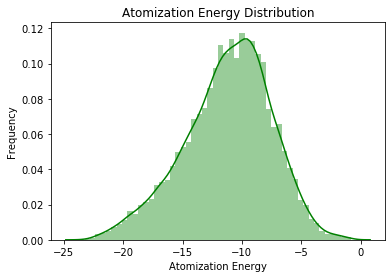

In [13]:
sns.distplot(df_eat, kde=True, color="g")
plt.xlabel('Atomization Energy')
plt.ylabel('Frequency')
plt.title('Atomization Energy Distribution');

In [14]:
# data taken from https://github.com/bhimmetoglu/RoboBohr/tree/master/data
df_eval = pd.read_csv(path+'/coulombL.csv', header=None, index_col=0)
df_out = df_eval[51]
df_eval = df_eval.drop([51], axis=1)

In [15]:
df_eval.head(10)

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,,,,,,,,,,,,,,,,,,,,,
25004,0.108338,0.121710,0.125796,0.129661,0.143059,0.148010,0.149170,0.157788,0.159308,0.162408,...,29.359494,30.020254,32.586196,40.854982,51.26412,53.218666,69.926234,133.875687,0.0,0
25005,0.154412,0.155939,0.163160,0.172905,0.187559,0.199397,0.218298,0.233281,0.255989,0.273780,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0
25006,0.130949,0.133728,0.140543,0.151511,0.161922,0.169285,0.174153,0.192567,0.216319,0.218838,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0
25009,0.130755,0.144113,0.144751,0.150850,0.156590,0.158825,0.167177,0.172883,0.180271,0.193070,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0
25011,0.139998,0.143839,0.149760,0.170269,0.176895,0.185890,0.204783,0.231890,0.235767,0.258813,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0
25017,0.138870,0.146974,0.163450,0.168191,0.182075,0.198975,0.204891,0.220762,0.227411,0.253550,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0
25019,0.139747,0.147746,0.155164,0.159304,0.171088,0.188501,0.204531,0.206723,0.215873,0.227807,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0
25023,0.138570,0.147427,0.155512,0.165709,0.168199,0.177093,0.185424,0.196259,0.207058,0.239146,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0
25032,0.134312,0.159233,0.183382,0.209968,0.223921,0.229835,0.292178,0.348409,0.423232,18.007082,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0


In [16]:
df_out.head(10)

0
25004   -19.013763
25005   -10.161019
25006    -9.376619
25009   -13.776438
25011    -8.537140
25017   -16.169604
25019   -17.378477
25023   -15.673737
25032   -10.427851
25042    -8.744178
Name: 51, dtype: float64

In [17]:
print(np.shape(df_eval), np.shape(df_out))

(16242, 50) (16242,)


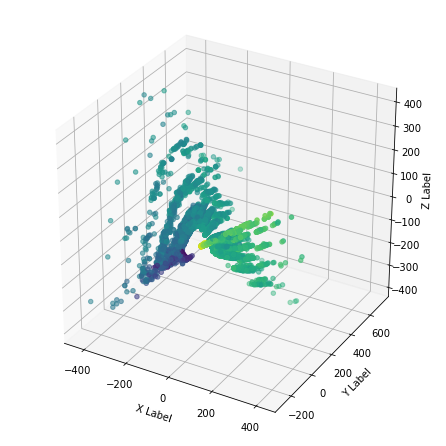

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
zee = pca.fit_transform(df_eval)
zee = pd.DataFrame(zee)


cmap = sns.cubehelix_palette(light=1, as_cmap=True)

fig = plt.figure(figsize=(6,6))

ax3d = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = -zee[0]
y = zee[1]
z = zee[2]


ax3d.scatter(x, y, z, c=df_out, marker='o')
ax3d.set_xlabel('X Label')
ax3d.set_ylabel('Y Label')
ax3d.set_zlabel('Z Label')

plt.show()

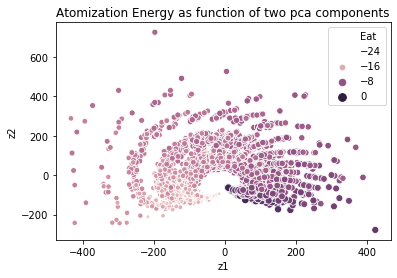

In [33]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
ax = sns.scatterplot(x=-zee[0], y=zee[1], size=df_eat,hue=df_eat, palette=cmap, sizes=(5, 60))
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Atomization Energy as function of two pca components');

In [19]:
def formatData(path):
# data taken from https://github.com/bhimmetoglu/RoboBohr/tree/master/data
    df = pd.read_csv(path + '/roboBohr.csv')
    df_master = df.drop(['Unnamed: 0', 'pubchem_id'], axis = 1)
    df_eat = df_master['Eat']
    df_features = df_master.drop('Eat', axis = 1)
    df_eval = pd.read_csv(path+'/coulombL.csv', header=None, index_col=0)
    df_out = df_eval[51]
    df_eval = df_eval.drop([51], axis=1)
    
#    print(df.head(10), df_master.head(10), df_features.head(10), df_eat.head(10), df_eval.head(10), df_out.head(10))
#    print(np.shape(df_eval), np.shape(df_out))
    
    return df_features, df_eat, df_eval, df_out

In [20]:
def splitData(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
#    print(np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test))
    return x_train, x_test, y_train, y_test

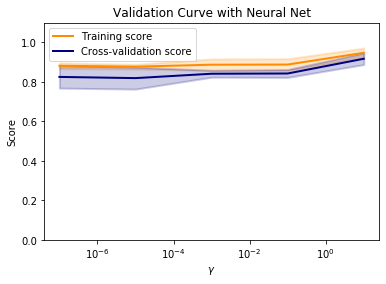

nn:  (array([[0.90126374, 0.86632193, 0.87738267],
       [0.89107987, 0.86167359, 0.8779883 ],
       [0.85774083, 0.9261186 , 0.87656713],
       [0.85782918, 0.92751442, 0.8775249 ],
       [0.96351218, 0.96437752, 0.91305823]]), array([[0.88409627, 0.74888134, 0.8420649 ],
       [0.87158763, 0.74208968, 0.84324142],
       [0.82100955, 0.86348564, 0.83879566],
       [0.81816388, 0.86675981, 0.84222548],
       [0.92797667, 0.94606989, 0.87683659]])) 0.8724412493203185


In [34]:
def NNet(x, y):
    x_train, x_test, y_train, y_test = splitData(x, y)
    
    hidden_layer_sizes = (50, 2) #default=(100,)
    activation = 'relu' #{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
    solver = 'adam' #{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’
    alpha = 1e-3 #default=0.0001
    batch_size = 'auto' #default=’auto’
    learning_rate = 'invscaling' #{‘constant’, ‘invscaling’, ‘adaptive’}, default=’constant’
    
#    nn = MLPRegressor(solver=solver, alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, activation = activation, batch_size = batch_size, learning_rate = learning_rate, random_state=1)
#    nn.fit(x_train, y_train)
#    y_predict = nn.predict(x_test)
#    print([y_predict[0:100], y_test[0:100]])
#    scores = cross_val_score(nn, x, y, cv=5)
    p_range = np.logspace(-7, 1, 5)
    train_scores, valid_scores = validation_curve(MLPRegressor(solver=solver, hidden_layer_sizes=hidden_layer_sizes, activation = activation, batch_size = batch_size, learning_rate=learning_rate, random_state=1), x, y, "alpha", p_range, cv=3)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    plt.title("Validation Curve with Neural Net")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(p_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(p_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)
    plt.semilogx(p_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(p_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2, color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
#    print(scores)
    return train_scores, valid_scores

scoresNN = NNet(df_eval, df_out)
print("nn: ", scoresNN, np.mean(scoresNN))

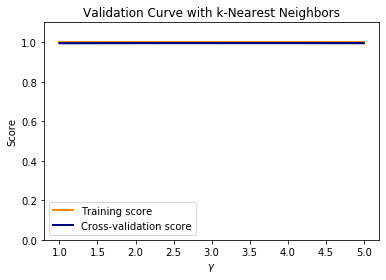

knn:  0.9977225752354483


In [27]:
def kNearestN(x, y):
    x_train, x_test, y_train, y_test = splitData(x, y)
    
    n_neighbors = 3 # default = 5
    weights = 'distance' #'uniform' (default), 'distance'
    algorithm = 'auto'#‘auto’ (default), ‘ball_tree’, ‘kd_tree’, ‘brute’
    
#    knn = KNeighborsRegressor(weights = weights, n_neighbors = n_neighbors, algorithm = algorithm, leaf_size = 90)
#    knn.fit(x_train, y_train)
#    #    y_predict = nn.predict(x_test)
#    #    print([y_predict[0:100], y_test[0:100]])
#    scores = cross_val_score(knn, x, y, cv=5)
    
    p_range = [1, 2, 3, 4, 5]
    train_scores, valid_scores = validation_curve(KNeighborsRegressor(weights = weights, algorithm = algorithm, leaf_size = 90), x, y, "n_neighbors", p_range, cv=3)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    plt.title("Validation Curve with k-Nearest Neighbors")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(p_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(p_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)
    plt.plot(p_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(p_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2, color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    #    print(scores)
    return train_scores, valid_scores

scoreskNN = kNearestN(df_eval, df_out)
print("knn: ", scores kNN, np.mean(scoreskNN))

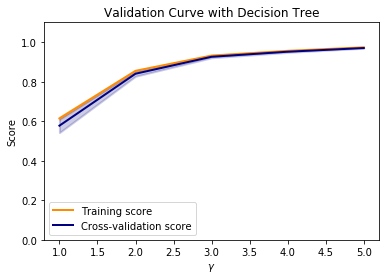

DT:  (array([[0.60502889, 0.62111738, 0.61629119],
       [0.8527458 , 0.85608041, 0.85557142],
       [0.93005089, 0.93260015, 0.93337933],
       [0.95605255, 0.95528173, 0.95667307],
       [0.97356082, 0.97369269, 0.97442985]]), array([[0.5941478 , 0.52831888, 0.60958649],
       [0.84743823, 0.82214898, 0.8507671 ],
       [0.93064285, 0.91895987, 0.92815083],
       [0.95559468, 0.94704992, 0.9518199 ],
       [0.97072651, 0.96876304, 0.97084685]])) 0.8595839377650373


In [28]:
def decTree(x, y):
    x_train, x_test, y_train, y_test = splitData(x, y)
    
    criterion = 'friedman_mse' # friedman_mse (default), mse, mae
    splitter = 'best' #best (default), random
    max_depth = 5 #default = None
    min_impurity_decrease = 1.0 #default = 0.0
    
#    dTree = DecisionTreeRegressor(criterion = criterion, splitter = splitter, min_impurity_decrease = min_impurity_decrease, max_depth = max_depth)
#    dTree.fit(x_train, y_train)
#    scores = cross_val_score(dTree, x, y, cv=5)
    
    p_range = [1, 2, 3, 4, 5]
    train_scores, valid_scores = validation_curve(DecisionTreeRegressor(criterion = criterion, splitter = splitter, min_impurity_decrease = min_impurity_decrease), x, y, "max_depth", p_range, cv=3)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    plt.title("Validation Curve with Decision Tree")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(p_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(p_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)
    plt.plot(p_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(p_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2, color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    
    return train_scores, valid_scores

scoresDT = decTree(df_eval, df_out)
print("DT: ", scoresDT, np.mean(scoresDT))

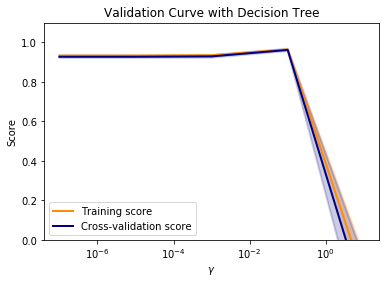

ABT:  (array([[ 0.93090591,  0.93270735,  0.93519352],
       [ 0.93081078,  0.93270045,  0.93569288],
       [ 0.93188603,  0.93302229,  0.93853152],
       [ 0.96199532,  0.96512049,  0.96551704],
       [-0.08052943, -0.14439958, -0.34592456]]), array([[ 0.93176651,  0.91912994,  0.93013838],
       [ 0.93153972,  0.91911578,  0.93064422],
       [ 0.93310456,  0.91959994,  0.93425244],
       [ 0.9657881 ,  0.9533148 ,  0.96565942],
       [-0.04941865, -0.53556295, -0.29434068]])) 0.7025987176109052


In [35]:
def adaBoostTree(x, y):
    x_train, x_test, y_train, y_test = splitData(x, y)
    
    loss = 'linear' #{‘linear’ (default), ‘square’, ‘exponential’}
    learning_rate = 1.0 #default = 1.0
    n_estimators = 300 #default = 50
    
#    adaBT = AdaBoostRegressor(learning_rate = 1.0, n_estimators=300, loss = loss)
#    adaBT.fit(x_train, y_train)
#    scores = cross_val_score(adaBT, x, y, cv=5)
    
    p_range = np.logspace(-7, 1, 5)
    train_scores, valid_scores = validation_curve(AdaBoostRegressor(n_estimators=300, loss = loss), x, y, "learning_rate", p_range, cv=3)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    plt.title("Validation Curve with Decision Tree")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(p_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(p_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)
    plt.semilogx(p_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(p_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2, color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    return train_scores, valid_scores

scoresABT = adaBoostTree(df_eval, df_out)
print("ABT: ", scoresABT, np.mean(scoresABT))

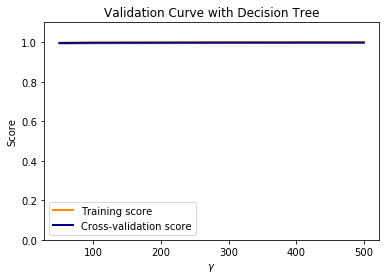

GBT:  (array([[0.9970344 , 0.99703643, 0.99724937],
       [0.99822046, 0.99816914, 0.99831494],
       [0.99925681, 0.99923557, 0.99930743],
       [0.99960283, 0.99957793, 0.9996138 ]]), array([[0.99540902, 0.99525845, 0.99543627],
       [0.99656653, 0.99650734, 0.99666776],
       [0.99751659, 0.99770911, 0.99760527],
       [0.99777598, 0.99799021, 0.99782395]])) 0.9977035669843843


In [36]:
def GradBoostTree(x, y):
    x_train, x_test, y_train, y_test = splitData(x, y)
    
    learning_rate = 0.1 #default = 0.1
    n_estimators = 300 #default = 100
    criterion = 'friedman_mse' # friedman_mse (default), mse, mae
    max_depth = 5 #default = 3
    ccp_alpha = 0.0 #default = 0.0
    
    GBT = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, criterion = criterion, random_state=0)
    GBT.fit(x_train, y_train)
    scores = cross_val_score(GBT, x, y, cv=5)
    
    p_range = [50, 100, 300, 500]
    train_scores, valid_scores = validation_curve(GradientBoostingRegressor(max_depth=max_depth, criterion = criterion, random_state=0), x, y, "n_estimators", p_range, cv=3)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    plt.title("Validation Curve with Decision Tree")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(p_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(p_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)
    plt.plot(p_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(p_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2, color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    return train_scores, valid_scores

scoresGBT = GradBoostTree(df_eval, df_out)
print("GBT: ", scoresGBT, np.mean(scoresGBT))

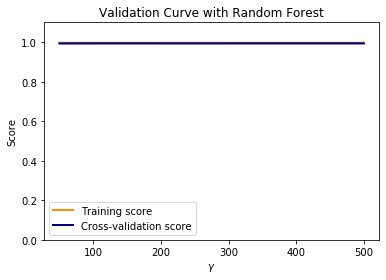

rForest:  (array([[0.99635787, 0.996182  , 0.99674649],
       [0.99646154, 0.99623045, 0.99681346],
       [0.99652692, 0.9962445 , 0.99684957],
       [0.99652273, 0.99627531, 0.99686666]]), array([[0.99399882, 0.99303812, 0.99424287],
       [0.99418474, 0.9932678 , 0.99441561],
       [0.99425171, 0.99332419, 0.99443787],
       [0.99422817, 0.99328295, 0.99445797]])) 0.9952170138672048


In [24]:
def randomForest(x, y):
    x_train, x_test, y_train, y_test = splitData(x, y)
    rForest = RandomForestRegressor(n_estimators = 100, min_samples_split = 3, max_features = 'auto', max_depth = 8)
    rForest.fit(x_train, y_train)
    #    y_predict = nn.predict(x_test)
    #    print([y_predict[0:100], y_test[0:100]])
    scores = cross_val_score(rForest, x, y, cv=5)
    
    p_range = [50, 100, 300, 500]
    train_scores, valid_scores = validation_curve(RandomForestRegressor(n_estimators = 100, min_samples_split = 3, max_features = 'auto', max_depth = 8), x, y, "n_estimators", p_range, cv=3)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    plt.title("Validation Curve with Random Forest")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(p_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(p_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)
    plt.plot(p_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(p_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2, color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    
    return train_scores, valid_scores

scoresrF = randomForest(df_eval, df_out)
print("rForest: ", scoresrF, np.mean(scoresrF))
